In [12]:
import pandas as pd
import argparse
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import seaborn as sns
import math

In [13]:
# read input file
filepath = "space_mountain.csv"
df = pd.read_csv(filepath)

In [14]:
# ------ SPLITTING DATASET ------
# train on 2014 (December), 2015, 2016, 2017, 2018, 2019, 2022 (excluding COVID years)
# test on 2023, 2024, 2025 (January - March)
# train_years = ['14', '15', '16', '17', '18', '19', '22']
# test_years = ['23', '24', '25']

train_years = ['14', '15', '16', '17', '18', '19', '22']
dev_years = ['23']
test_years = ['24', '25']

df['Year'] = df['Date'].apply(lambda x: x.split('/')[-1])  # Extract year as a string
df = df[df['Time of Day'] >= 450]
train_df = df[df['Year'].isin(train_years)]  # Filter rows where Year is in train_years
dev_df = df[df['Year'].isin(dev_years)] # Filter rows where Year is in dev_years
test_df = df[df['Year'].isin(test_years)]  # Filter rows where Year is in train_years

train_df.shape, dev_df.shape, test_df.shape

((50962, 7), (8215, 7), (11288, 7))

In [15]:
# ------ TRAINING ------
# getting unique day and time values for training model
week_day_list = np.unique(train_df['Day of Week'])
time_list = np.unique(train_df['Time of Day'])

week_day_list, time_list

(array(['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday',
        'Wednesday'], dtype=object),
 array([ 450,  480,  510,  540,  570,  600,  630,  660,  690,  720,  750,
         780,  810,  840,  870,  900,  930,  960,  990, 1020, 1050, 1080,
        1110, 1140, 1170, 1200, 1230, 1260, 1290, 1320, 1350, 1380, 1410]))

In [16]:
# getting averages across time of day per week day
avg_vals = {}
for day in week_day_list:
    for time in time_list:
        avg = (train_df[(train_df['Day of Week'] == day) & (train_df['Time of Day'] == time)]['Wait Time'].mean())
        avg_vals[(day, time)] = avg

# removing NaN values
avg_vals = {k: int(v) for k, v in avg_vals.items() if not math.isnan(v)}

avg_vals

{('Friday', np.int64(450)): 11,
 ('Friday', np.int64(480)): 10,
 ('Friday', np.int64(510)): 19,
 ('Friday', np.int64(540)): 23,
 ('Friday', np.int64(570)): 33,
 ('Friday', np.int64(600)): 41,
 ('Friday', np.int64(630)): 46,
 ('Friday', np.int64(660)): 52,
 ('Friday', np.int64(690)): 55,
 ('Friday', np.int64(720)): 57,
 ('Friday', np.int64(750)): 54,
 ('Friday', np.int64(780)): 54,
 ('Friday', np.int64(810)): 53,
 ('Friday', np.int64(840)): 55,
 ('Friday', np.int64(870)): 58,
 ('Friday', np.int64(900)): 58,
 ('Friday', np.int64(930)): 59,
 ('Friday', np.int64(960)): 58,
 ('Friday', np.int64(990)): 61,
 ('Friday', np.int64(1020)): 58,
 ('Friday', np.int64(1050)): 63,
 ('Friday', np.int64(1080)): 63,
 ('Friday', np.int64(1110)): 61,
 ('Friday', np.int64(1140)): 64,
 ('Friday', np.int64(1170)): 62,
 ('Friday', np.int64(1200)): 65,
 ('Friday', np.int64(1230)): 62,
 ('Friday', np.int64(1260)): 59,
 ('Friday', np.int64(1290)): 56,
 ('Friday', np.int64(1320)): 65,
 ('Friday', np.int64(1350)): 

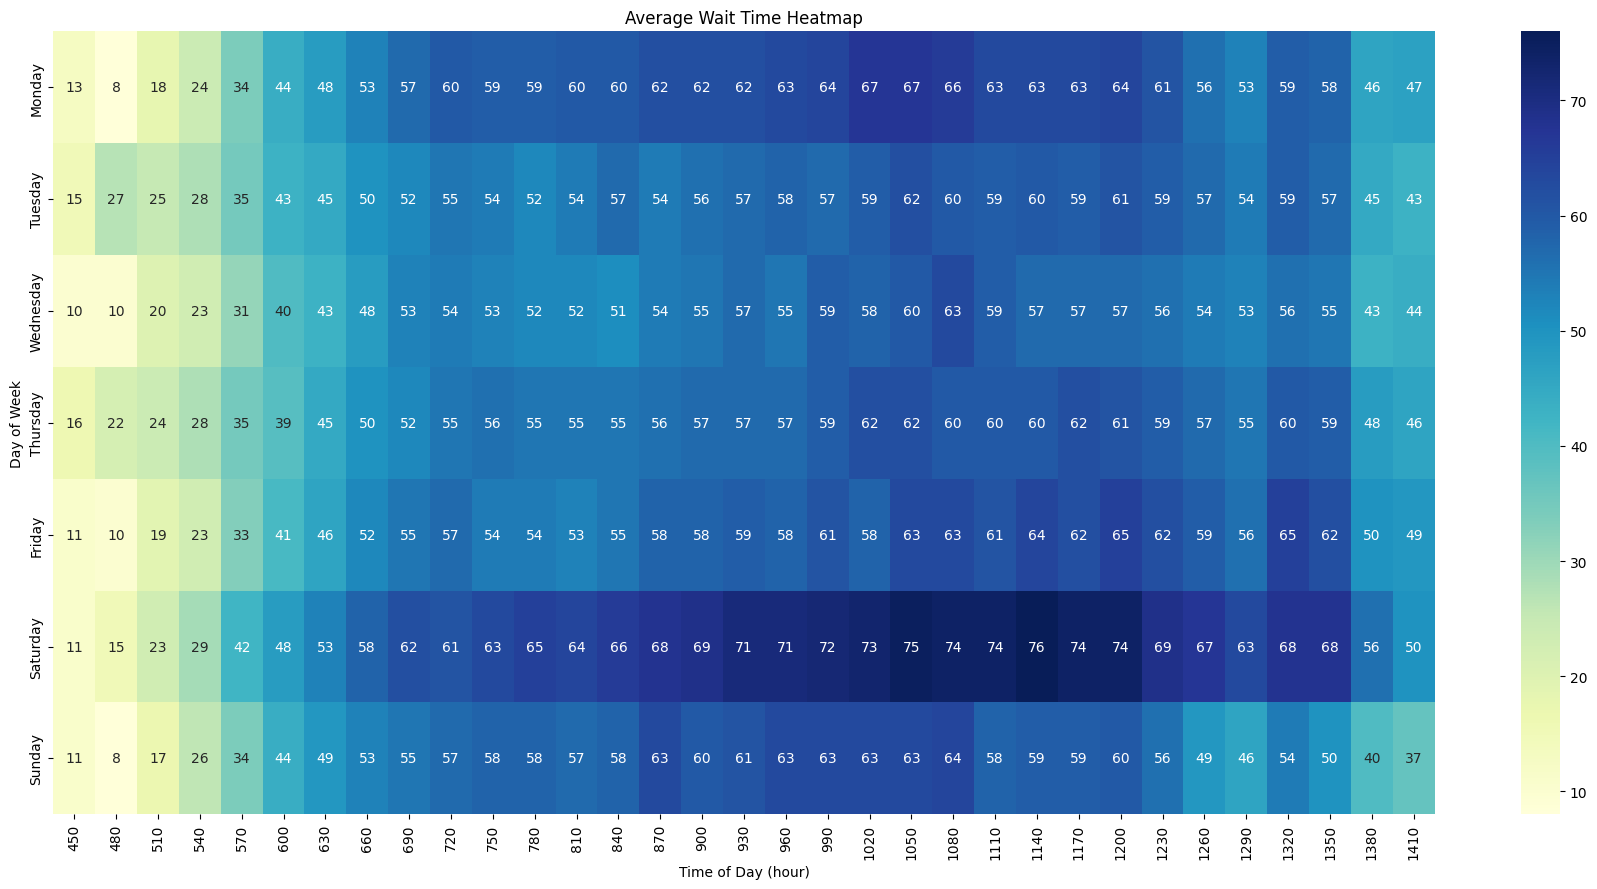

In [17]:
# Convert avg_vals dict to DataFrame
heatmap_df = pd.DataFrame([
    {"Day": day, "Time": time, "Wait": wait}
    for (day, time), wait in avg_vals.items()
])

# Pivot to get matrix format: rows = Day, columns = Time
pivot_df = heatmap_df.pivot(index="Day", columns="Time", values="Wait")

# Optional: reorder days for proper weekday sequence
ordered_days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
pivot_df = pivot_df.reindex(ordered_days)

# Plot
plt.figure(figsize=(18, 9))
sns.heatmap(pivot_df, cmap="YlGnBu", annot=True, fmt=".0f")
plt.title("Average Wait Time Heatmap")
plt.xlabel("Time of Day (hour)")
plt.ylabel("Day of Week")
plt.tight_layout()
plt.show()

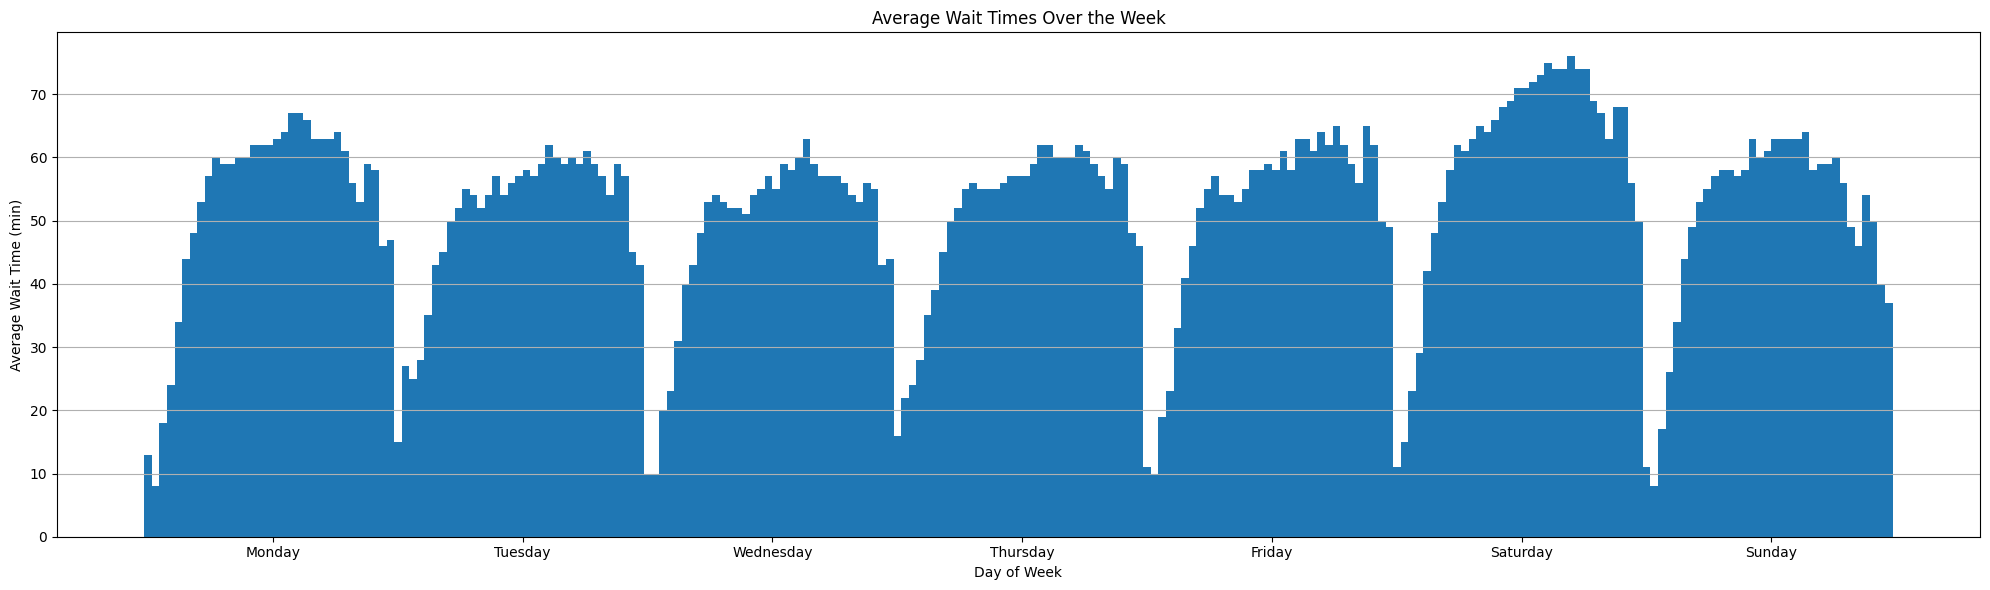

In [18]:
# Step 1: Sort the data properly
heatmap_df["Day"] = pd.Categorical(heatmap_df["Day"], categories=ordered_days, ordered=True)
heatmap_df = heatmap_df.sort_values(by=["Day", "Time"])

# Step 2: Plot bar chart using index as x-values
plt.figure(figsize=(20, 6))
plt.bar(range(len(heatmap_df)), heatmap_df["Wait"], width=1)

# Step 3: Compute day label positions (centered)
slots_per_day = heatmap_df["Time"].nunique()
day_centers = [(i + 0.5) * slots_per_day for i in range(len(ordered_days))]

plt.xticks(ticks=day_centers, labels=ordered_days)
plt.title("Average Wait Times Over the Week")
plt.xlabel("Day of Week")
plt.ylabel("Average Wait Time (min)")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()




In [19]:
# Testing on Dev Set
# ------ TESTING ------
# getting the actual values for the test set
y_dev_actual = dev_df['Wait Time'].values
y_dev_pred = []

for index, row in dev_df.iterrows():
    day = row['Day of Week']
    time = row['Time of Day']
    if (day, time) in avg_vals:
        # if the day and time is in the training set, use the average value
        y_dev_pred.append(avg_vals[(day, time)])
    else:
        y_dev_pred.append(np.nan)

# replacing nan values with mean of the training set
y_dev_pred = [int(x) if not math.isnan(x) else int(np.mean(list(avg_vals.values()))) for x in y_dev_pred]

# # calculating RMSE
rmse = np.sqrt(mean_squared_error(y_dev_actual, y_dev_pred))
print("RMSE: {}".format(rmse))

RMSE: 17.54779578592746


In [20]:
# ------ TESTING ------
# getting the actual values for the test set
y_test_actual = test_df['Wait Time'].values
y_pred = []

for index, row in test_df.iterrows():
    day = row['Day of Week']
    time = row['Time of Day']
    if (day, time) in avg_vals:
        # if the day and time is in the training set, use the average value
        y_pred.append(avg_vals[(day, time)])
    else:
        y_pred.append(np.nan)

# replacing nan values with mean of the training set
y_pred = [int(x) if not math.isnan(x) else int(np.mean(list(avg_vals.values()))) for x in y_pred]

y_pred[:10]

[13, 8, 18, 24, 34, 44, 48, 53, 57, 59]

In [21]:
# # calculating RMSE
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
print("RMSE: {}".format(rmse))

RMSE: 17.315198176195835


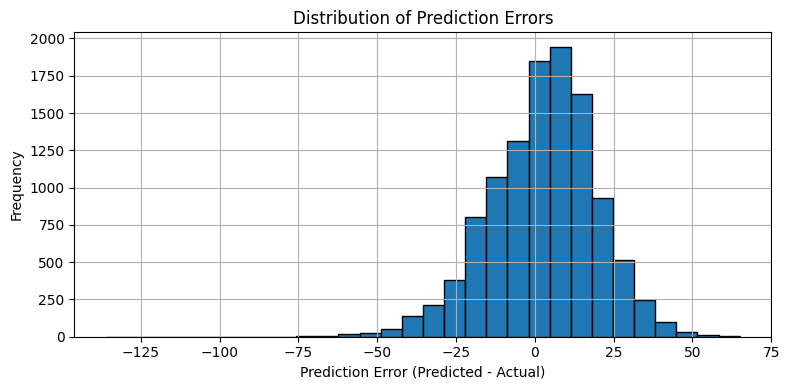

In [22]:
errors = np.array(y_pred) - np.array(y_test_actual)

plt.figure(figsize=(8, 4))
plt.hist(errors, bins=30, edgecolor='black')
plt.title("Distribution of Prediction Errors")
plt.xlabel("Prediction Error (Predicted - Actual)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()



In [23]:
# save errors to CSV file
errors_df = pd.DataFrame(errors, columns=['Prediction Error'])
errors_df.to_csv('baseline.csv', index=False)